# Challenge Project #2: Nuclear Masses and BART

### Author(s): Alexandra Semposki, Rahul Jain, John Yannotty

### 26 June 2023

Welcome to one of the two challenge problems of the BMM session! You've made it to undiscovered country!

Now that you've gained a good level of understanding from the first hands-on notebook, we'll expand to look at the application of Bayesian Model Mixing (BMM) to nuclear masses. Let's first do an import of the masses data and see what it looks like.

In [1]:
# required imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from scipy.stats import norm
from scipy.special import gamma
import sys
import os

In [ ]:
# define plot function for nuclear masses
def plot_nuclear(df,col):
    fig = plt.figure()
    ax = plt.axes()
    fig.patch.set_facecolor('white')
    fig.set_dpi(150)
    s = ax.scatter(df['N'], df['Z'], c=df[col],marker='s',label=col+('  (B.E. in MeV)'))
    ax.set_xlabel('N (neutrons)')
    ax.set_ylabel('Z (protons)')
    ax.legend()
    fig.colorbar(s, ax=ax)
    plt.show()

## Exploring nuclear mass data

In [ ]:
# import nuclear masses from csv file
df = pd.read_csv('BMM_Masses.csv')
display(df)

,Z,N,Skyrme,Skyrme_sd,UNEDF,UNEDF_sd,Gogny,Gogny_sd,Astro,Astro_sd
0,8,8,128.742274,1.021639,123.454881,2.820379,127.518375,0.721858,126.831211,1.695344
1,8,9,133.845949,1.071011,128.688709,3.272675,132.759547,0.136036,131.066870,1.956041
2,8,10,143.982260,1.351196,138.141011,3.377607,141.073010,0.102521,139.967529,2.648074
3,8,11,148.012559,1.558553,142.325192,3.565541,145.222260,0.689189,143.448188,2.123883
4,8,12,156.386178,1.957625,149.956568,3.615505,152.473156,0.803892,152.453847,0.744093
...,...,...,...,...,...,...,...,...,...,...
7539,110,225,2219.208355,18.999176,2229.333030,3.479975,2222.906807,0.680828,2231.412431,4.373357
7540,110,226,2221.311081,19.333940,2231.427017,3.568115,2225.272999,0.570042,2233.378089,4.041948
7541,110,227,2222.516370,19.711846,2232.853821,3.736911,2226.150401,0.683689,2235.123748,3.922672
7542,110,228,2224.509358,19.977482,2234.825847,3.811971,2228.358439,0.514583,2237.344407,2.848802


OK, great! So how do we interpret the data we just imported?

Check out the column headers; the __Z__ and __N__ columns indicate the number of protons and neutrons, respectively, in a given nucleus. The four other categories are averages over sets of models that can be described by the types of methods they use---for example, __Skyrme__ uses the Skyrme energy density functional.

If you're very curious about the forms of these models individually, check out the reference list below.

- Skyrme: Density Functional Theory models based on Skyrme Energy Density Functional
    - SkM* - https://www.sciencedirect.com/science/article/pii/0375947482904031?via%3Dihub
    - SkP - https://www.sciencedirect.com/science/article/pii/0375947484904330?via%3Dihub
    - SLy4 - https://iopscience.iop.org/article/10.1088/0031-8949/1995/T56/034
    - SV-min - https://journals.aps.org/prc/abstract/10.1103/PhysRevC.79.034310


- UNEDF: Density Functional Theory models also based on Skyrme Energy Density Functional
    - UNEDF0 - https://journals.aps.org/prc/abstract/10.1103/PhysRevC.82.024313
    - UNEDF1 - https://journals.aps.org/prc/abstract/10.1103/PhysRevC.85.024304
    - UNEDF2 - https://journals.aps.org/prc/abstract/10.1103/PhysRevC.89.054314


- Gogny: Density Functional Theory models based on Gogny Energy Density Functional
    - BCPM - https://journals.aps.org/prc/abstract/10.1103/PhysRevC.87.064305
    - D1M - https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.102.242501


- Astro: More phenomenological mass models commonly used in nuclear astrophysics
    - FRDM2012 - https://www.sciencedirect.com/science/article/pii/S0092640X1600005X?via%3Dihub
    - HFB24 - https://journals.aps.org/prc/abstract/10.1103/PhysRevC.88.024308
    
    
Now we will plot one of the models over the nuclear chart, along with its uncertainties. These were assigned by averaging the individual model uncertainties within each of the groups of models above. The variable we're plotting in is the __binding energy__ in MeV (abbreviated B.E. in the plot legend).

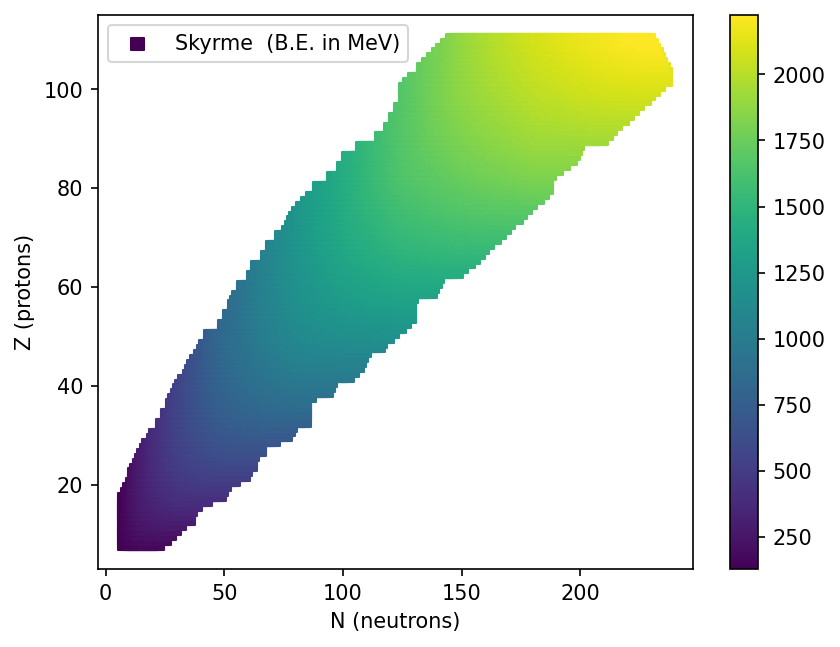

In [ ]:
plot_nuclear(df,'Skyrme')

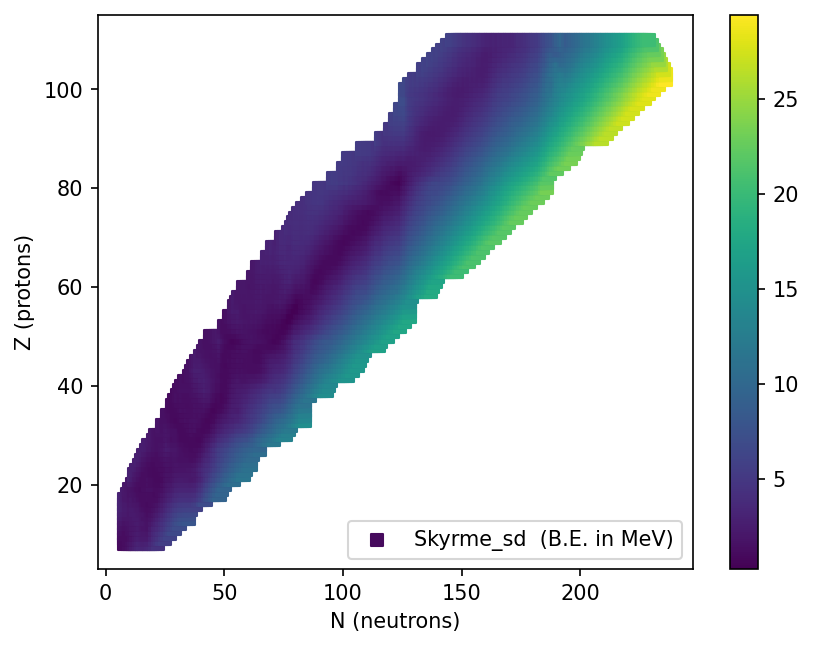

In [ ]:
plot_nuclear(df,'Skyrme_sd')

__Question__: You can see that the binding energy uncertainties above are very small for the line passing diagonally through the center of the nuclear chart band. Can you guess why that might be happening?

---

# Challenge Project 2: **BART-BMM: Mixing with 2-Dimensional Input Spaces**
## **Introduction**

[All BART descriptions and code below credited to John Yannotty]

This part of the challenge uses Bayesian Additive Regression Trees, which are able to handle multidimensional inputs. This BMM approach leverages observational data and the physics-based predictions from each model to obtain better global prediction and interpretation of the physical system. In our case, this means that we'll be able to mix our four nuclear mass models over the entire nuclear chart in both $N$ and $Z$ instead of just looking at a slice of one or the other.
$\newcommand{\xvec}{\boldsymbol x}$ $\newcommand{\wvec}{\boldsymbol w}$

## **The BART-BMM Model**

Consider $K$ physics models, each intended to explain the underlying physical system $f_\dagger(\xvec)$ across different subregions of the domain. Denote each physics-based model by $f_1(\xvec),\ldots,f_K(\xvec)$. For simplicity, we assume each $f_k(\boldsymbol{x})$ is implemented as a deterministic simulator with calibrated parameters.

The BART-BMM model combines the known physics in each simulator using a mean-based approach. Given observational data $Y_1,\ldots,Y_n$ at p-dimensional inputs $\xvec_1,\ldots,\xvec_n$, the BMM model is defined as

\begin{equation}
  Y(\xvec_i) = \sum_{k=1}^K w_k(\xvec_i)f_k(\xvec_i) + \epsilon_i, \quad \epsilon_i \stackrel{\small{\text{ind}}}{\sim} N(0,\sigma^2)
\end{equation}
for $i = 1,\ldots,n$.


### **Overview of Tree Models**

A tree model is a flexible and non-parametric method for estimating an unknown function $f(\xvec)$ with input vector $\xvec$. The objective of a tree model is to recursively partition the input space using binary splitting rules of the form $x_v < c$, where $v \in \{1,.\ldots,p \}$ and $c$ is a cutpoint from a discretized subset of the real numbers. Each partition corresponds to a terminal node and is assigned a constant value, which serves as the prediction of $f(\xvec)$. An example tree with respect to a 2-dimensional input space is shown below.    


![Image of Tree](https://github.com/jcyannotty/Taweret/raw/develop/docs/source/images/tree_split.png)

$\\[5 pt]$

Panel (a) illustrates an example of a tree structure with three terminal nodes $\eta_{11},\eta_{21}$, and $\eta_{31}$. Panel (b) displays the partitions of the input space, with associated terminal node parameters $\boldsymbol{\mu}_{b1}$, $b=1,2,3$. Using the tree model, each $\xvec$ in the input domain is mapped to one of these three values.

### **The Weight Model**

Denote the weight vector as $\wvec(\xvec) = (w_1(\xvec),\ldots,w_K(\xvec))^\top$. Then $\wvec(\xvec)$ is modeled by
\begin{equation}
  \wvec(\xvec) = \sum_{j = 1}^m \boldsymbol{g}(\xvec,T_j,M_j)
\end{equation}
where $\boldsymbol{g}(\xvec,T_j,M_j)$ is the output of the jth tree $T_j$ with the associated set of parameters $M_j$. Main features of the weight functions include:

* Implicit regularization via a multivariate Gaussian prior.
* Each weight $w_k(\xvec)$ prefers the interval $[0,1]$, but is not strictly confined to this region.
* No sum-to-one constraint is imposed.
* Defined using flexible tree bases which are learned using the observational data.

### **Setting Prior Distributions**

Two of the priors in the BART model are described below. The descriptions are followed by plots of the prior densities at various settings of the hyperparameters.

#### *The weight function prior*

Each of the $K$ weight functions are implicitly regularized via a Gaussian prior. Assuming an ensemble of $m$ trees are used to learn the weight functions, the (implicit) prior for each weight is defined by

\begin{equation}
    w_l(x) \mid \mathcal{T} \sim N(0.5, m\tau^2), \quad l = 1,\ldots,K,
\end{equation}
where $K$ is the number of models under consideration and $\mathcal{T} = \{T_1,\ldots,T_m\}$ is the set of trees. Meanwhile, $\tau$ is specified as
\begin{equation}
    \tau = \frac{1}{2k\sqrt{m}}
\end{equation}
where $k$ is a tuning parameter. Increasing $k$ limits the flexibility of each weight and concentrates the corresponding prior around the central point of 0.5.  

#### *The error variance prior*

The error variance is assigned a scaled inverse chi-square distribution, denoted by $\;\sigma^2 \sim \lambda\nu/\chi^2_\nu$. The hyperparameters of $\nu$ and $\lambda$ control the shape and scale of the prior respectively. Increasing $\nu$ will result in a prior with a higher peak, while increasing $\lambda$ will shift the prior to the right.


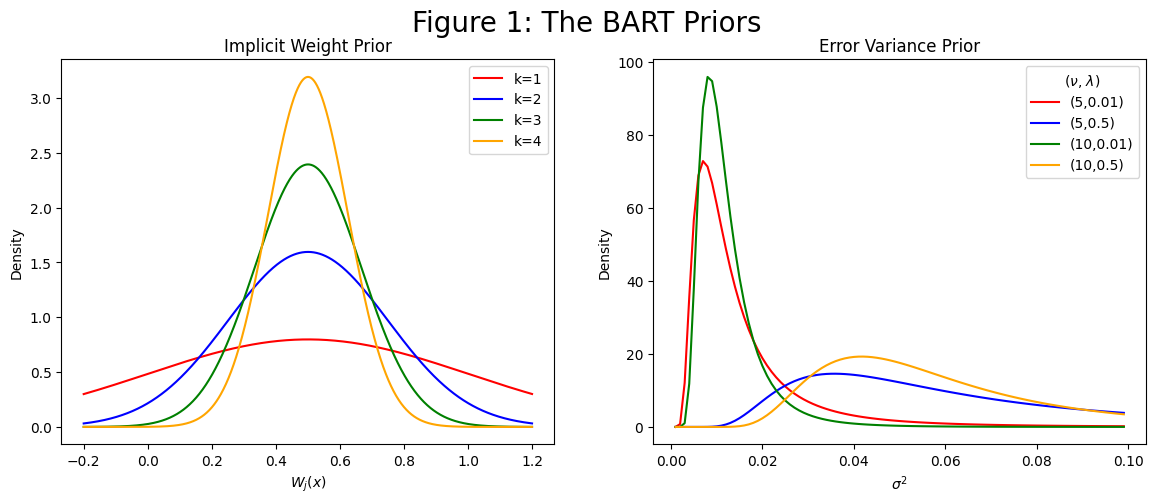

In [2]:
# Create Figure 1: The BART Priors
# Define different values for m*tau^2
mtau2_vec = 0.25*np.array([1,1/4,1/9,1/16]) # k = 1,2,3,4 respectively

# Evaluate the weight prior density of a grid of points
w_grid = np.arange(-0.2,1.2,0.001)
wprior1 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[0]))
wprior2 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[1]))
wprior3 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[2]))
wprior4 = norm.pdf(w_grid, 0.5, np.sqrt(mtau2_vec[3]))

# Now evaluate the variance prior
def scaled_inv_chi2(sig2, nu, lam):
    den = (lam*nu/2)**(nu/2)/(gamma(nu/2)*sig2**(1+nu/2))*np.exp(-nu*lam/(2*sig2))
    return den

s_grid = np.arange(0.001,0.1,0.001)
sprior1 = scaled_inv_chi2(s_grid, 5, 0.01)
sprior2 = scaled_inv_chi2(s_grid, 5, 0.05)
sprior3 = scaled_inv_chi2(s_grid, 10, 0.01)
sprior4 = scaled_inv_chi2(s_grid, 10, 0.05)


# Plot the prior
fig, ax = plt.subplots(1,2, figsize = (14,5))
ax[0].plot(w_grid, wprior1, color = 'red')
ax[0].plot(w_grid, wprior2, color = 'blue')
ax[0].plot(w_grid, wprior3, color = 'green')
ax[0].plot(w_grid, wprior4, color = 'orange')
ax[0].set_title("Implicit Weight Prior")
ax[0].set_xlabel("$W_j(x)$")
ax[0].set_ylabel("Density")
ax[0].legend(["k=1","k=2","k=3","k=4"], loc = "upper right")

# Plot the prior
ax[1].plot(s_grid, sprior1, color = 'red')
ax[1].plot(s_grid, sprior2, color = 'blue')
ax[1].plot(s_grid, sprior3, color = 'green')
ax[1].plot(s_grid, sprior4, color = 'orange')
ax[1].set_title("Error Variance Prior")
ax[1].set_xlabel("$\sigma^2$")
ax[1].set_ylabel("Density")
ax[1].legend(["(5,0.01)","(5,0.5)","(10,0.01)","(10,0.5)"], loc = "upper right", title = "($\\nu$, $\lambda$)")

fig.suptitle("Figure 1: The BART Priors", size = 20)
plt.show();

## **Installation of Ubuntu Package**
The Bayesian Additive Regression Tree (BART) approach for model mixing is implemented in C++ and built as a Ubuntu package. The following three steps can be used to download and install the package.

1. Download the package from the corresponding github repository. This is done using the `!wget` command.

2. Install the package using the `!dpkg` command.

3. Reset the library cache using the `!ldconfig` command.


In [3]:
!wget -q https://github.com/jcyannotty/OpenBT/raw/main/openbt_mixing0.current_amd64-MPI_Ubuntu_20.04.deb

In [4]:
!dpkg -i openbt_mixing0.current_amd64-MPI_Ubuntu_20.04.deb

Selecting previously unselected package openbt.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack openbt_mixing0.current_amd64-MPI_Ubuntu_20.04.deb ...
Unpacking openbt (0.current-MPI) ...
Setting up openbt (0.current-MPI) ...


In [5]:
!ldconfig

### **Working with Taweret**
First, we need to clone Taweret from github and switch to the develop branch. While doing so, we will also make Taweret our current directory using the cd command.

In [6]:
# Clone the Taweret Repo
!git clone https://github.com/jcyannotty/Taweret.git
!cd Taweret && git checkout develop

Cloning into 'Taweret'...
remote: Enumerating objects: 2025, done.
remote: Counting objects: 100% (2025/2025), done.
remote: Compressing objects: 100% (874/874), done.
remote: Total 2025 (delta 1052), reused 1949 (delta 1033), pack-reused 0
Receiving objects: 100% (2025/2025), 75.21 MiB | 28.45 MiB/s, done.
Resolving deltas: 100% (1052/1052), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


Finally, we can add Taweret to the system path and import the required modules.

In [7]:
sys.path.insert(0,'/content/Taweret')

In [8]:
# Taweret Imports
from Taweret.models.polynomial_models import sin_exp, cos_exp, sin_cos_exp
from Taweret.mix.trees import Trees


## **Example**

This example demonstrates the BART-BMM model on a 2-dimensional example with two different simulators. Assume the true system is defined by $$f_\dagger(x) = \sin(x_1) + \cos(x_2),$$
over the domain $(x_1,x_2) \in [-\pi,\pi]\times [-\pi,\pi]$.  Furthermore, consider a model set which defines the two simulators under consideration in terms of Taylor series expansions of $\sin(x_1)$ and $\cos(x_2).$ The simulators are defined by $f_1(x)$ and $f_2(x)$ as shown below:

$\\[5 pt]$

\begin{align}
    f_1(x) &= \sum_{j=0}^7 \frac{s^{(j)}(x_1)}{j!}(x_1-\pi)^j + \sum_{k=0}^{10} \frac{c^{(k)}(x_2)}{k!}(x_2-\pi)^k  \\[8 pt]  
    f_2(x) &= \sum_{j=0}^{13} \frac{s^{(j)}(x_1)}{j!}(x_1+\pi)^j + \sum_{k=0}^6 \frac{c^{(k)}(x_2)}{k!}(x_2+\pi)^k.
\end{align}

$\\[5 pt]$

where $x = (x_1,x_2)$, $s^{(j)}(x_1)$ denotes the jth derivative of $\sin(x_1)$, and $c^{(k)}(x_1)$ denotes the kth derivative of $\cos(x_2)$.

The simulator, $f_1(x)$ involves Taylor series expansions of $\sin(x_1)$ and $\cos(x_2)$ about $\pi$. Meanwhile, $f_2(x)$ is constructed using two Taylor series expansions about $-\pi$.


### **Training Data**
Prior to mixing, we can generate training data over a two-dimensional grid. This is done by first generating a set of training inputs using the `grid_2d_design(...)` function. The function generates points with a space filling design. The 2-dimensional input space is divided into a $n_1 \times n_2$ grid. Then, an input $\xvec = (x_1,x_2)$ is randomly generated in each rectangle of the grid. This results in a total of $n = n_1n_2$ training points.

The training points are passed through the true function of $f_\dagger(\xvec) = \sin(x_1) + \cos(x_2)$ and random noise is added to simulate observational data, $Y_1,\ldots,Y_n$. The example below generates data from 80 training points, though one can easily use a smaller or larger training set.

In [9]:
## Functions for design points
# n1 = number of bins in the x1 dimension
# n2 = number of bins in the x2 dimension
# n = n1*n2 is the total training size
def grid_2d_design(n1,n2, xmin = [-1,-1], xmax = [1,1]):
  # Generate n uniform rvs
  n = n1*n2
  ux = np.random.uniform(0,1,n)
  uy = np.random.uniform(0,1,n)

  # Dimensions for each rectangle
  x1_len = (xmax[0] - xmin[0])/n1
  x2_len = (xmax[1] - xmin[1])/n2
  xgrid = [[x, y] for x in range(n1) for y in range(n2)]
  xgrid = np.array(xgrid).transpose()

  # Get points
  x1 = ux*x1_len + x1_len*xgrid[0] + xmin[0]
  x2 = uy*x2_len + x2_len*xgrid[1] + xmin[1]

  # Join data
  xdata = np.array([x1,x2]).transpose()
  return xdata

The training inputs are generated over the rectangle $[-\pi,\pi]^2$. The design points are shown in the figure below. Then, the observational data is independently generated according to
\begin{equation}
    Y_i \sim  N(f_\dagger(x_i),\sigma^2)
\end{equation}
where $x_i = (x_{i1},x_{i2})$ is the ith training input for $i=1,\ldots,n$. In this example, $n = 80$ and $\sigma = 0.1$.

In [10]:
# Generate Data
# Pick the grid dimensions
nx1 = 10; nx2 = 8

# Total training size
n_train = nx1*nx2

# Generate inputs
x_train = grid_2d_design(nx1,nx2,[-np.pi,-np.pi],[np.pi,np.pi])

# Generate observational data with true standard deviation of 0.1
f0_train = np.sin(x_train.transpose()[0]) + np.cos(x_train.transpose()[1])
y_train = f0_train + np.random.normal(0,0.1,n_train)


The design of the experiment is shown below. Clearly the training points are spread out across the entire domain.

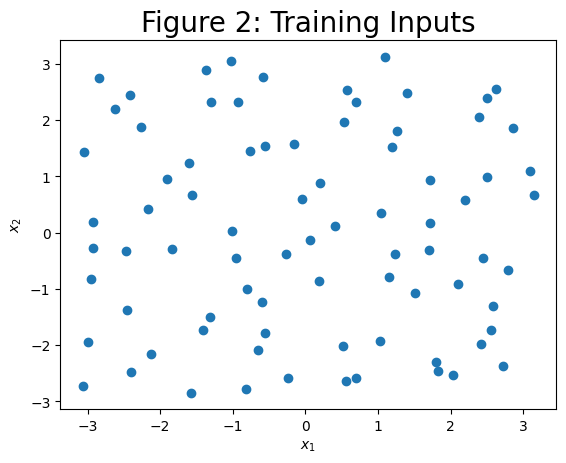

In [11]:
# Create Figure 2: The Training inputs
plt.scatter(x_train.transpose()[0],x_train.transpose()[1])
plt.title("Figure 2: Training Inputs", size = 20)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

### **The Model Set**

Now we can visualize the true function and the two simulators under consideration. Each surface is shown below. Note, the plots are truncated in areas where an expansion rapidly increases or decreases. This is done only for visual purposes.

The first plot illustrates the true surface. This surface has various peaks and valleys across the input domain. We will see each simulator can be used to explain one of these features of the true surface. The plot is generated by evaluating $f_\dagger(x)$ over a dense grid of points across the input domain.

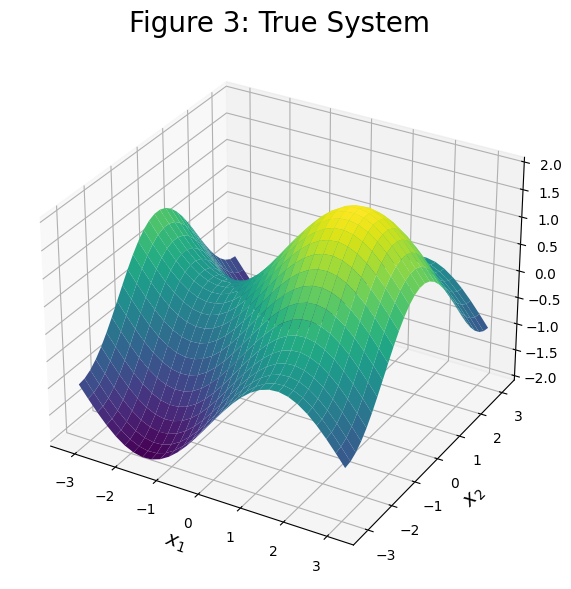

In [12]:
# Create Figure 3: The true surface
# Plot the surfaces
n_test = 30
x1_test = np.outer(np.linspace(-np.pi, np.pi, n_test), np.ones(n_test))
x2_test = x1_test.copy().transpose()
f0_test = (np.sin(x1_test) + np.cos(x2_test))
x_test = np.array([x1_test.reshape(x1_test.size,),x2_test.reshape(x1_test.size,)]).transpose()

# Define color map
cmap = plt.get_cmap('viridis')

# Creating figure
fig = plt.figure(figsize =(11, 7))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
plt.title("Figure 3: True System", size = 20)
plt.xlabel("$x_1$", size = 14)
plt.ylabel("$x_2$", size = 14)
ax.set_zlim([-2,2])

# show plot
plt.show()

Now we can view the two simulators we wish to mix. The first simulator is comprised of two Taylor series expansions centered about $\pi$, hence it provides higher fidelity predictions in the upper right corner of the domain. The second simulator is comprised of two Taylor series expansions centered about $-\pi$. Additionally, its Taylor series expansion of $\sin(x)$ is a high-fidelity approximation across the entire interval of $[-\pi,\pi]$. Hence $f_2(x)$ provides higher fidelity predictions in the bottom half of the domain.

The surfaces produced by each simulator are shown below.

#### **The $f_1(x)$ surface:**

The first expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(\pi,\pi)$. Based on the plot below, we can see the first expansion is designed to approximate the peak of the true system in this upper right corner of the domain. Meanwhile, the prediction becomes less accurate as $x_1$ or $x_2$ moves away from $\pi$. Note for visual purposes, the plot below truncates the approximation in these less accurate regions.

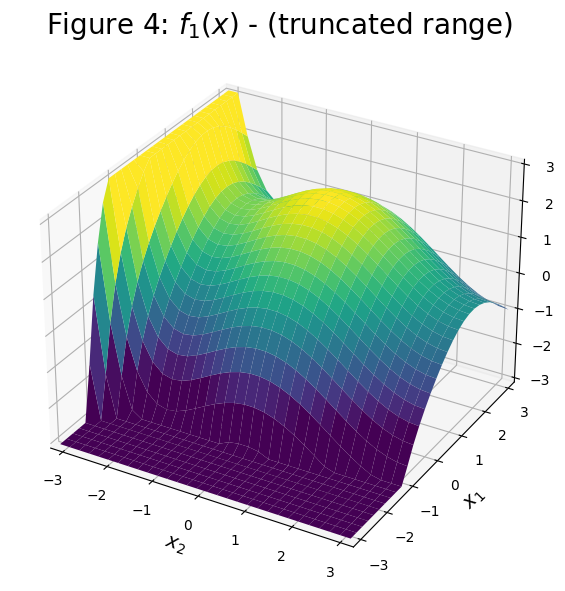

In [13]:
# Create Figure 4: The f1 surface
# Plot the first simulator
sin7 = sin_exp(7,np.pi)
cos10 = cos_exp(10,np.pi)

f1_sin = sin7.evaluate(x1_test.transpose()[0])[0]
f1_cos = cos10.evaluate(x1_test.transpose()[0])[0]

f1_sin_grid = np.outer(f1_sin, np.ones(n_test))
f1_cos_grid = np.outer(f1_cos, np.ones(n_test)).transpose()

f1_test = f1_sin_grid + f1_cos_grid

# Subset the data for the plot (only for visualization)
f1_test_filter = f1_test.copy()
for i in range(n_test):
    f1_test_filter[i][np.where(f1_test_filter[i]>3)] = 3.05
    f1_test_filter[i][np.where(f1_test_filter[i]<-3)] = -3.05

# Creating figure
fig = plt.figure(figsize =(11, 7))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(x2_test, x1_test, f1_test_filter, cmap = cmap, vmin = -2, vmax = 2)
ax.set_zlim([-3,3])
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-np.pi,np.pi])
plt.title("Figure 4: $f_1(x)$ - (truncated range)", size = 20)
plt.xlabel("$x_2$", size = 14)
plt.ylabel("$x_1$", size = 14)

# show plot
plt.show()

#### **The $f_2(x)$ surface**

The second expansion is shown below. The predicted surface is accurate for points $(x_1,x_2)$ close to the point $(-\pi,-\pi)$. Additionally, the expansion of $\sin(x_1)$ is a high-fidelity approximation of $\sin(x_1)$ across the interval $[-\pi,\pi]$. Hence, from the plot below, $f_2(x)$ can be used to approximate the valley and curvature in the true function for points in the bottom region of the domain. Once again, the surface is truncated for visual purposes in regions where the expansion rapidly increases.

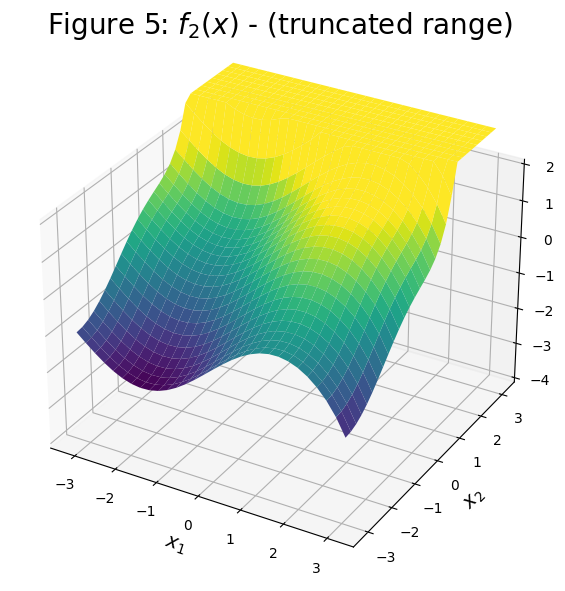

In [14]:
# Create Figure 5: The f2 surface
# Plot the second simulator
sin13 = sin_exp(13,-np.pi)
cos6 = cos_exp(6,-np.pi)

f2_sin = sin13.evaluate(x1_test.transpose()[0])[0]
f2_cos = cos6.evaluate(x1_test.transpose()[0])[0]

f2_sin_grid = np.outer(f2_sin, np.ones(n_test))
f2_cos_grid = np.outer(f2_cos, np.ones(n_test)).transpose()

f2_test = f2_sin_grid + f2_cos_grid

# Subset the data for the plot (only for visualization)
f2_test_filter = f2_test.copy()
for i in range(n_test):
    f2_test_filter[i][np.where(f2_test_filter[i]>3)] = 3.05
    f2_test_filter[i][np.where(f2_test_filter[i]<-3)] = -3.05


# Creating figure
fig = plt.figure(figsize =(11, 7))
ax = plt.axes(projection ='3d')

# Creating plot
ax.set_zlim([-4,2])
ax.plot_surface(x1_test, x2_test, f2_test_filter,cmap = cmap, vmin = -2, vmax = 2)
plt.title("Figure 5: $f_2(x)$ - (truncated range)", size = 20)
plt.xlabel("$x_1$", size = 14)
plt.ylabel("$x_2$", size = 14)

# show plot
plt.show()

Alternatively, we can view the accuracy of each individual Taylor Series expansions. The first two expansions (red) are added together to obtain the first simulator, while the second two expansions (blue) are added together to obtain the second simulator. The following observations are made:

* The first row of plots suggest the first simulator, $f_1(x)$, is an accurate approximation of the true function for positive $x_1$ and $x_2$.

* The second row of plots suggest the second simulator, $f_2(x)$, is an accurate approximation of the true function for negative $x_2$ and any values of $x_1$.

Hence, we expect $f_1(x)$ to be influential in the upper right corner of the domain and $f_2(x)$ to be influential in the bottom half of the domain. These results should be reflected in the final posterior weights for the BMM model.

Text(0.5, 0.98, 'Figure 6: Taylor Series Expansions')

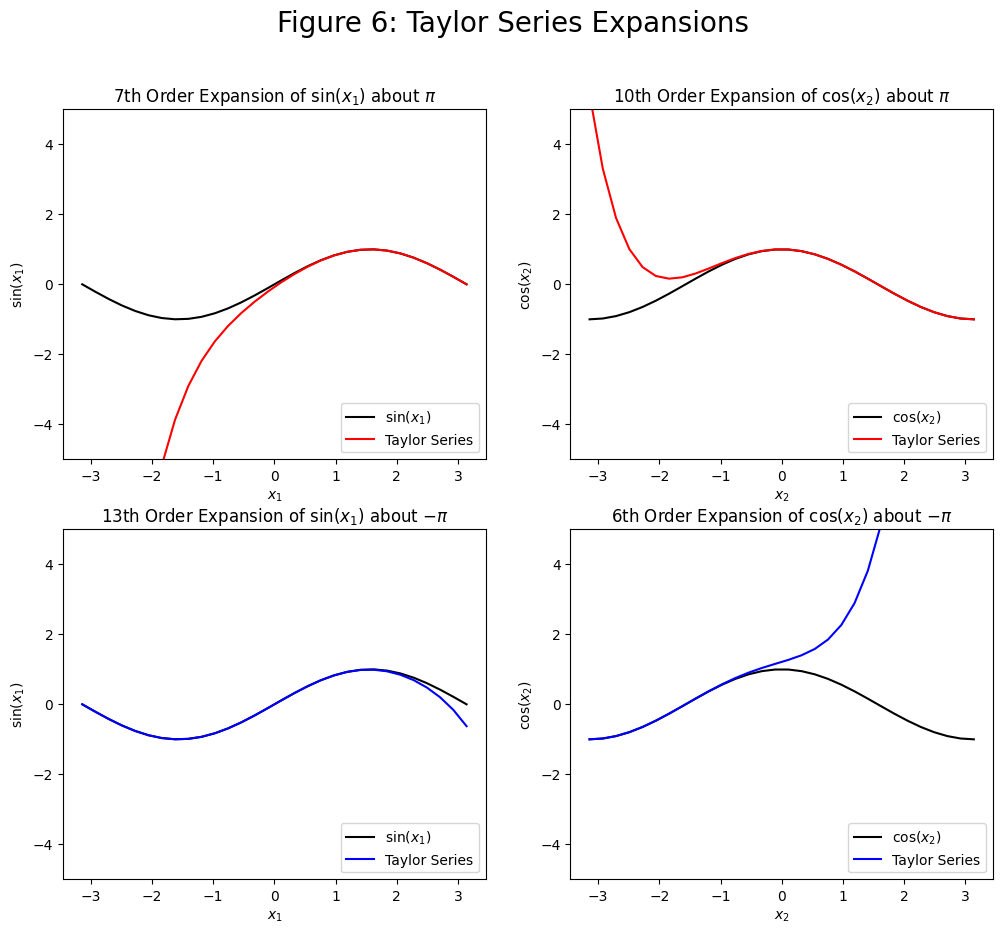

In [15]:
# Create Figure 6: Taylor Series Expansions
# Store the 4 individual Taylor series expansions and plot titles
exp_list = [f1_sin, f1_cos, f2_sin, f2_cos]
exp_title = ["7th Order Expansion of $\sin(x_1)$ about $\pi$","10th Order Expansion of $\cos(x_2)$ about $\pi$",\
             "13th Order Expansion of $\sin(x_1)$ about $-\pi$ ", "6th Order Expansion of $\cos(x_2)$ about $-\pi$"]

# Plot the marginal effects of each expansion
k = 0
fig, ax = plt.subplots(2,2,figsize = (12,10))
for i in range(2):
    if i == 0:
        exp_color = 'red'
    else:
        exp_color = 'blue'
    for j in range(2):
        if j == 0:
            ax[i][j].plot(x1_test.transpose()[0], np.sin(x1_test.transpose()[0]), color = 'black')
            exp_label = "$\sin(x_1)$"
        else:
            ax[i][j].plot(x1_test.transpose()[0], np.cos(x1_test.transpose()[0]), color = 'black')
            exp_label = "$\cos(x_2)$"

        ax[i][j].plot(x1_test.transpose()[0], exp_list[k], color = exp_color)
        ax[i][j].set_ylim(-5,5)
        ax[i][j].set_ylabel(exp_label)
        ax[i][j].set_xlabel("$x_"+str(j+1)+"$")
        ax[i][j].set_title(exp_title[k], size = 12)
        ax[i][j].legend([exp_label, "Taylor Series"],loc = "lower right")
        # Increment total plot index
        k = k + 1
fig.suptitle("Figure 6: Taylor Series Expansions", size = 20)

## **The BART-BMM Model**

The BART-BMM model is trained using the following steps.

1. Define the model set using the three lines of code shown below. The first two lines define a class instance for each Taylor series expansion. The third line of code defines the model set.  

In [16]:
# Define the model set
f1 = sin_cos_exp(7,10,np.pi,np.pi) # 7th order sin(x1) + 10th order cos(x2)
f2 = sin_cos_exp(13,6,-np.pi,-np.pi) # 13th order sin(x1) + 6th order cos(x2)
model_dict = {'model1':f1, 'model2':f2}


2. Define the class instance of the BART-BMM model using the `Trees` class. For this example, the class instance is called `mix`.

3. Set the prior information using the `set_prior()` method. One can see the affect of $k$ and $\nu$ in Figure 1. Also note, $\lambda = \text{overallsd}^2$.

4. Fit the model using the `train()`. This requires the user to pass in the data and relevant MCMC arguments.  

In [17]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict, google_colab = True)

# Set prior information
mix.set_prior(k=2.0,ntree=30,overallnu=5,overallsd=0.01,inform_prior=False)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 5000, nadapt = 2000, nskip = 1000, adaptevery = 200, minnumbot = 4, tc = 2)


Results stored in temporary path: /tmp/openbtpy_jn7f0r9l
Running model...


5. Obtain the predictions from the mixed function and the corresponding weight functions using the methods `predict()` and `predict_weights()`, respectively. Both methods require an array of test points and a confidence level.

In [18]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


### **Predictions**

The predicted system can be displayed by executing the following three code chunks. The first chunk displays the mean predicted surface while the second compares the mean  prediction with the true system using a heat map. The third chunk displays the mean residuals.  

#### **Questions:**

**Q1.** *What region(s) of the domain result in an accurate approximation of the true system? What region(s) of the domain are not accurately predicted by the BMM model? Do these results make sense, given the strengths and weaknesses of each expansion?*


Text(0.5, 0.98, 'Figure 7: True versus Predicted System')

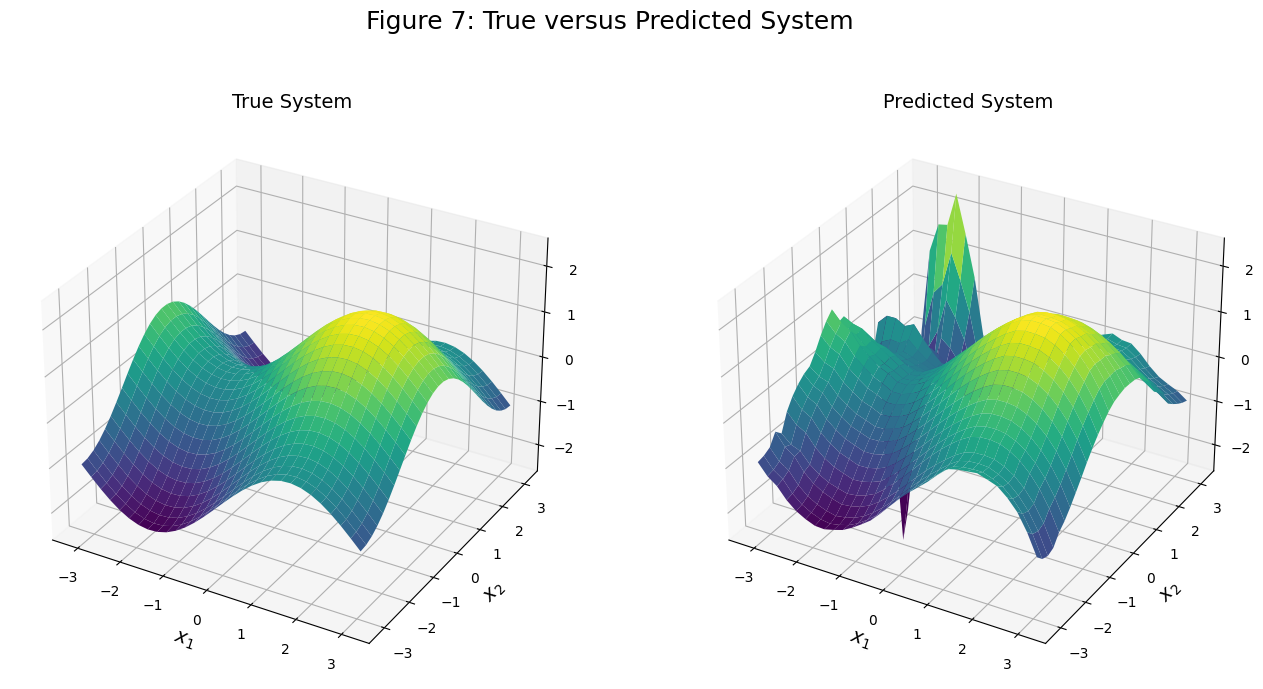

In [19]:
# Create Figure 7: The true vs. predicted surface
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(x1_test, x2_test, f0_test, cmap = cmap, vmin = -2, vmax = 2)
ax.set_title("True System", size = 14)
ax.set_xlabel("$x_1$", size = 14)
ax.set_ylabel("$x_2$", size = 14)
ax.set_zlim([-2.5,2.5])

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x1_test, x2_test, pmean.reshape(x1_test.shape), cmap = cmap, vmin = -2, vmax = 2)
ax.set_title("Predicted System", size = 14)
ax.set_xlabel("$x_1$", size = 14)
ax.set_ylabel("$x_2$", size = 14)
ax.set_zlim([-2.5,2.5])

fig.suptitle("Figure 7: True versus Predicted System", size = 18)

Another way to visually compare the posterior mean prediction and the true system is by a heat map, as shown below.

In [ ]:
# Create Figure 8: The true vs. predicted system as heat maps
# Heat map comparing the surfaces
fig, ax = plt.subplots(1,2, figsize = (12,5))

pcm1 = ax[0].pcolormesh(f0_test.transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[0].set_title("True System", size = 16)
ax[0].set(xlabel = "$x_1$", ylabel = "$x_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm1,ax = ax[0])


# Predicted mean
pcm2 = ax[1].pcolormesh(pmean.reshape(x1_test.shape).transpose(),cmap = cmap, vmin = -2.5, vmax = 2.5)
ax[1].set_title("Posterior Mean Prediction", size = 16)
ax[1].set(xlabel = "$x_1$", ylabel = "$x_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm2,ax = ax[1])
fig.suptitle("Figure 8: True versus Predicted System", size = 18)

Finally, we can plot the mean residual, which is defined as $\hat{r}(x) = f_\dagger(x) - \hat{f}_\dagger(x)$.  

In [ ]:
# Create Figure 9: Posterior Mean resiudals
cmap_rb = plt.get_cmap("RdBu")
fig, ax = plt.subplots(1,1, figsize = (6,5))

pcm1 = ax.pcolormesh((f0_test - pmean.reshape(x1_test.shape)).transpose(),cmap = cmap_rb, vmin = -2.5, vmax = 2.5)
ax.set_title("Figure 9: Posterior Mean Residuals", size = 14)
ax.set(xlabel = "$x_1$", ylabel = "$x_2$")
ax.xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm1,ax = ax)


### **Weight Functions**

Now, we can plot the mean weight functions from the BMM model using the code below. The weight functions help identify where each simulator is accurate or inaccurate. The mean weight functions are shown in Figure 10 and the sum of the mean weight functions is shown in Figure 11.

#### **Questions:**

**Q2.** *Based on the weight functions, in what region of the domain is the first simulator highly influential in the BMM prediction? Meanwhile, in what regions is the first simulator not influential in the BMM prediction?*



**Q3.** *Based on the weight functions, in what region of the domain is the second simulator highly influential in the BMM prediction? Meanwhile, in what regions is the second simulator not influential in the BMM prediction?*


**Q4.** *Using Figure 11, do you see any similarities between the sum of the mean weights and the resiudal plot in Figure 9? Considering what we know about each simulator, what might this suggest about the sum of the weight functions?*


**Q5.** *Given the design of each simulator from Figures 3-6, do these results make sense?*


In [ ]:
# Create Figure 10: The posterior mean weight functions
cmap_hot = plt.get_cmap('hot')
w1 = wmean.transpose()[0]
w2 = wmean.transpose()[1]

w1_mean = wmean.transpose()[0]
w1_mean = w1_mean.reshape(x1_test.shape).transpose()

w2_mean = wmean.transpose()[1]
w2_mean = w2_mean.reshape(x1_test.shape).transpose()

w_sum = w1_mean + w2_mean

fig, ax = plt.subplots(1,2, figsize = (12,5))
pcm0 = ax[0].pcolormesh(w1_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
ax[0].set_title("Posterior Mean of $w_1(x)$", size = 14)
ax[0].set(xlabel = "$x_1$", ylabel = "$x_2")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm0,ax = ax[0])

pcm1 = ax[1].pcolormesh(w2_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
ax[1].set_title("Posterior Mean of $w_2(x)$", size = 14)
ax[1].set(xlabel = "$x_1$", ylabel = "$x_2$")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm1,ax = ax[1])
fig.suptitle("Figure 10: Posterior Mean Weight Functions", size = 16)


In [ ]:
# Create Figure 11: The posterior mean of the sum of the weight functions
fig, ax = plt.subplots(1,1, figsize = (7,5))

pcm2 = ax.pcolormesh(w_sum,cmap = cmap_hot, vmin = 0, vmax = 1.15)
ax.set_title("Figure 11: Posterior Mean of \n $w_1(x) + w_2(x)$", size = 18)
ax.set(xlabel = "$X_1$", ylabel = "$X_2$")
ax.xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax.yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm2,ax = ax)


### **Error Standard Deviation**
Finally, the posterior distribution of the error standard deviation is shown below. The true value of $\sigma = 0.10$.

#### **Questions:**

**Q6.** *Does the BMM model accurately estimate $\sigma$?*


In [ ]:
# Plot the posterior of the error standard deviation
fig = plt.figure(figsize=(6,5))
plt.hist(mix.posterior, zorder = 2)
plt.title("Figure 12: Posterior Error Standard Deviation")
plt.xlabel("$\sigma$") # Update Label
plt.ylabel("Frequency") # Update Label
plt.grid(True, color='lightgrey', zorder = 0)
plt.show()


**Additional Exercises:**

**Q7.** *Explore the affect of the tuning parameters on the BMM model. For example, consider setting $k=1.0$ or $k=3.0$ to increase or decrease the flexibility of the weights. Next decrease the number of trees by setting $ntree = 1$ or $ntree = 5$. What happens to the mean prediction of the system and the mean weights?*  

**Q8.** *Now consider adding a third simulator to our model set. From the original problem, we know the first two simulators struggle in the upper left corner of the domain. Thus, consider a third simulator designed for this region as shown below: \begin{align}
    f_3(x) &= \sum_{j=0}^{7} \frac{s^{(j)}(x_1)}{j!}(x_1+\pi)^j + \sum_{k=0}^8 \frac{c^{(k)}(x_2)}{k!}(x_2-\pi)^k.
\end{align} This simulator is constructed using a 7th-order Taylor series expansion of $\sin(x_1)$ about $-\pi$ and an 8th-order Taylor series expansion of $\cos(x_2)$ about $\pi$. Create a new model set with all three simulators and fit the BART-BMM model using $10$ trees and $k=2.5$. How do your results change?*


In [ ]:
## Question 8 Steps:
## Define your model set here...


In [ ]:
## Create a new instance of the Trees class, set the prior, and train the model here...


In [ ]:
## Get the predictions of the system and the weight functions here...


In [ ]:
## Plot the heat map of the predictions here....


In [ ]:
## Plot the residuals here....


In [ ]:
## Plot the mean weight functions here....
